In [44]:
import os
import numpy as np
import pandas as pd
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from keras.models import Model,Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam,SGD,RMSprop
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping
from keras.utils import plot_model

In [45]:
TRAIN_DATA_PATH = r"C:\Users\ssrke\Downloads\emotionsdatasets\train"
TEST_DATA_PATH = r"C:\Users\ssrke\Downloads\emotionsdatasets\test"
IMAGE_SIZE = (48, 48)
BATCH_SIZE = 64
NUM_CLASSES = 7
EPOCHS = 100

In [46]:
train_counts = {expression: len(os.listdir(os.path.join(TRAIN_DATA_PATH, expression))) 
                for expression in os.listdir(TRAIN_DATA_PATH)}
train_counts_df = pd.DataFrame(train_counts, index=['train'])

In [47]:
test_counts = {expression: len(os.listdir(os.path.join(TEST_DATA_PATH, expression))) 
               for expression in os.listdir(TEST_DATA_PATH)}
test_counts_df = pd.DataFrame(test_counts, index=['test'])

In [48]:
print("Number of images in training set:")
print(train_counts_df)

Number of images in training set:
       angry  disgusted  fearful  happy  neutral   sad  surprised
train   3995        436     4097   7215     4965  4830       3171


In [49]:
print("\nNumber of images in test set:")
print(test_counts_df)


Number of images in test set:
      angry  disgusted  fearful  happy  neutral   sad  surprised
test    958        111     1024   1774     1233  1247        831


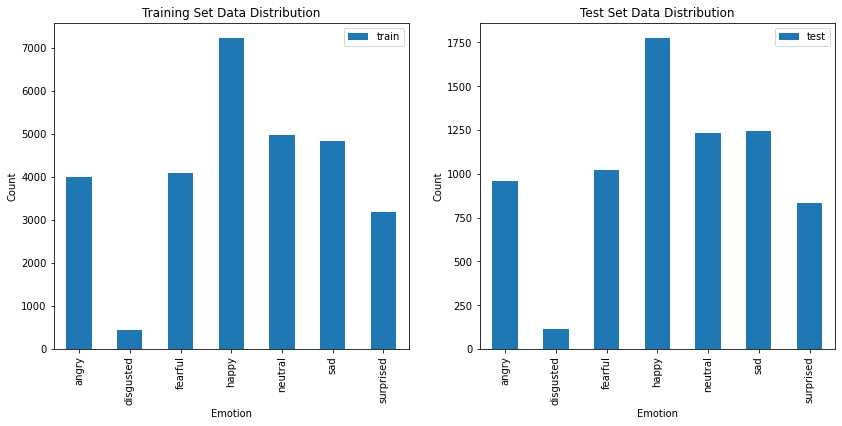

In [50]:
# Plotting data distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
train_counts_df.transpose().plot(kind='bar', ax=plt.gca())
plt.title('Training Set Data Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
test_counts_df.transpose().plot(kind='bar', ax=plt.gca())
plt.title('Test Set Data Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

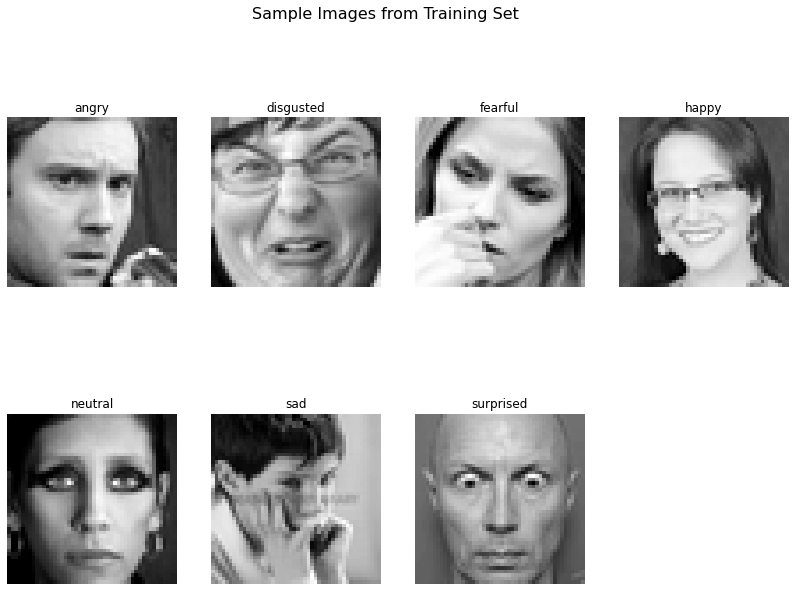

In [51]:
# Plotting sample images from each class
plt.figure(figsize=(14, 10))
for i, expression in enumerate(os.listdir(TRAIN_DATA_PATH), 1):
    img_path = os.path.join(TRAIN_DATA_PATH, expression, os.listdir(os.path.join(TRAIN_DATA_PATH, expression))[0])
    img = plt.imread(img_path)
    plt.subplot(2, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(expression)
    plt.axis('off')
plt.suptitle('Sample Images from Training Set', fontsize=16)
plt.show()

In [52]:
# Loading and analyzing a sample image to understand pixel intensity distribution
sample_img_path = os.path.join(TRAIN_DATA_PATH, 'happy', os.listdir(os.path.join(TRAIN_DATA_PATH, 'happy'))[0])
sample_img = plt.imread(sample_img_path)

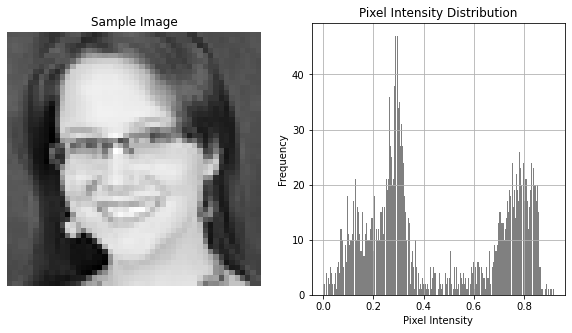

In [53]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_img, cmap='gray')
plt.title('Sample Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.hist(sample_img.ravel(), bins=256, color='gray')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [54]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, zoom_range=0.3, horizontal_flip=True)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [55]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [58]:
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [59]:
model = create_model(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1), num_classes=NUM_CLASSES)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Ba  (None, 22, 22, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 22, 22, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 64)       

In [60]:
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = callbacks.ModelCheckpoint('model_detect_emotional.h5', save_best_only=True, verbose=1, monitor='val_loss')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_delta=0.00001, verbose=1)

tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=5)  # Log histograms every 5 epochs
csv_logger = callbacks.CSVLogger('training.log')

callbacks_list = [checkpoint, reduce_lr, csv_logger, tensorboard_callback, early_stopping]

In [61]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.n // test_generator.batch_size,
    callbacks=callbacks_list)

Epoch 1/100
448/448 [==============================] - ETA: 0s - loss: 2.1794 - accuracy: 0.2317
Epoch 1: val_loss improved from inf to 1.80068, saving model to model_detect_emotional.h5


C:\Users\ssrke\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 260s 562ms/step - loss: 2.1794 - accuracy: 0.2317 - val_loss: 1.8007 - val_accuracy: 0.2649 - lr: 0.0010
Epoch 2/100
448/448 [==============================] - ETA: 0s - loss: 1.7655 - accuracy: 0.3180
Epoch 2: val_loss improved from 1.80068 to 1.64545, saving model to model_detect_emotional.h5
448/448 [==============================] - 239s 533ms/step - loss: 1.7655 - accuracy: 0.3180 - val_loss: 1.6454 - val_accuracy: 0.3715 - lr: 0.0010
Epoch 3/100
448/448 [==============================] - ETA: 0s - loss: 1.6130 - accuracy: 0.3739
Epoch 3: val_loss improved from 1.64545 to 1.62068, saving model to model_detect_emotional.h5
448/448 [==============================] - 243s 542ms/step - loss: 1.6130 - accuracy: 0.3739 - val_loss: 1.6207 - val_accuracy: 0.3424 - lr: 0.0010
Epoch 4/100
448/448 [==============================] - ETA: 0s - loss: 1.5236 - accuracy: 0.4100
Epoch 4: val_loss did not improve from 1.62068
448/448 [=====================

In [63]:
evaluation = model.evaluate(train_generator)
print(f"\nTrain Accuracy: {evaluation[1] * 100:.2f}%")

449/449 [==============================] - 235s 524ms/step - loss: 0.8665 - accuracy: 0.6699

Train Accuracy: 66.99%


In [64]:
evaluation = model.evaluate(test_generator)
print(f"\nTest Accuracy: {evaluation[1] * 100:.2f}%")

113/113 [==============================] - 49s 436ms/step - loss: 0.9652 - accuracy: 0.6371

Test Accuracy: 63.71%


In [65]:
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

113/113 [==============================] - 13s 109ms/step


In [66]:
conf_matrix = confusion_matrix(test_generator.classes, y_pred)

In [67]:
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:\n", classification_report(test_generator.classes, y_pred, target_names=class_labels))


Classification Report:
               precision    recall  f1-score   support

       angry       0.54      0.57      0.56       958
   disgusted       0.67      0.34      0.45       111
     fearful       0.49      0.35      0.40      1024
       happy       0.84      0.85      0.85      1774
     neutral       0.56      0.66      0.61      1233
         sad       0.51      0.53      0.52      1247
   surprised       0.76      0.78      0.77       831

    accuracy                           0.64      7178
   macro avg       0.62      0.58      0.59      7178
weighted avg       0.63      0.64      0.63      7178



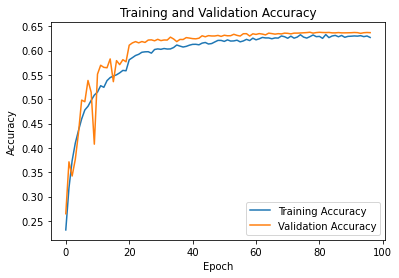

In [68]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

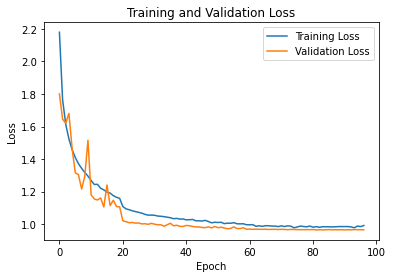

In [69]:
import matplotlib.pyplot as plt

# Access the loss history from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [78]:
# Save the entire model
model.save(r"C:\Users\ssrke\Downloads\emotionsdatasets\model\model.h5")


1/1 [==============================] - 0s 147ms/step
Predicted emotion for C:/Users/ssrke/Downloads/emotionsdatasets/model/test_image1.jpg : sad


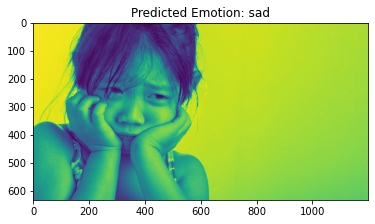

1/1 [==============================] - 0s 21ms/step
Predicted emotion for C:\Users\ssrke\Downloads\emotionsdatasets\model\1920_face-new-675956.jpg : Happy


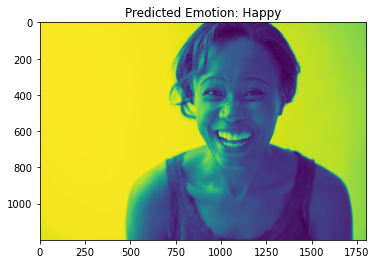

1/1 [==============================] - 0s 31ms/step
Predicted emotion for C:\Users\ssrke\Downloads\emotionsdatasets\model\360_F_342851651_BV9SYWnoTPSu3kq6e82zG7H8eEt20wd1.jpg : sad


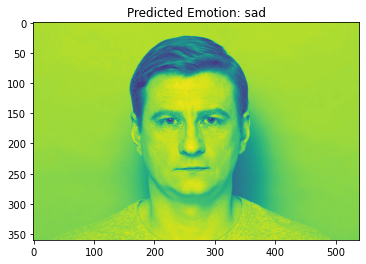

In [94]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model(r"C:\Users\ssrke\Downloads\emotionsdatasets\model\model.h5")  # Replace "model_weights.h5" with the path to your trained model file

# Define a function to preprocess images
def preprocess_image(image_path, target_size):
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale')  # Convert to grayscale
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Load test photos
test_image_paths = [
    "C:/Users/ssrke/Downloads/emotionsdatasets/model/test_image1.jpg", 
    r"C:\Users\ssrke\Downloads\emotionsdatasets\model\1920_face-new-675956.jpg",
    r"C:\Users\ssrke\Downloads\emotionsdatasets\model\360_F_342851651_BV9SYWnoTPSu3kq6e82zG7H8eEt20wd1.jpg"
    
]  
# Replace with paths to your test images

# Define target size for preprocessing
target_size = (48, 48)  # Adjust according to your model's input size

# Define class names
class_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Surprise', 4: 'sad',  5: 'Neutral',6: 'Happy'}

# Make predictions on test photos
for image_path in test_image_paths:
    # Preprocess the image
    img_array = preprocess_image(image_path, target_size)
    # Make prediction
    predictions = model.predict(img_array)
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions[0])
    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]
    # Print the predicted class name
    print("Predicted emotion for", image_path, ":", predicted_class_name)
    
    # Optionally, visualize the image with predicted class
    plt.imshow(image.load_img(image_path, color_mode='grayscale'))
    plt.title(f"Predicted Emotion: {predicted_class_name}")
    plt.show()
